# Gibbs sampling for Dirichlet process-based mixtures

In this notebook, I demonstrate the naive sampler in Orbanz' lecture notes and McEachern's collapsed sampler for DP mixtures.

In [3]:
%pylab inline
figsize(10,5)

Populating the interactive namespace from numpy and matplotlib


In [4]:
# Import necessary libraries
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import matplotlib.pyplot as plt
import scipy.stats as spst
import time as time
import pickle as pkl

For simplicity, we consider one-dimensional mixtures of Gaussians with known unit variance. The model thus reads
$$
\xi = \sum w_i\delta_{\mu_i} \sim \text{DP}(\alpha, G)
$$
$$
x_1,\dots,x_n \sim \sum w_i\mathcal{N}(\cdot\vert \mu_i,1) \text{ i.i.d. }
$$

We also assume the base measure to be Gaussian $\mathcal{N}(0,\sigma^2)$, so that for $\mu,x\in\mathbb{R}$, we have the following conjugation property
$$
G(\phi) p(x\vert \phi) = \mathcal{N}(x\vert \phi,1)\mathcal{N}(\phi\vert 0,\sigma^2) = \mathcal{N}(x\vert 0,1+\sigma^2) \mathcal{N}\left(\phi\bigg\vert\frac{\sigma^2 x}{1+\sigma^2}, \frac{\sigma^2}{1+\sigma^2}\right).
$$

In [7]:
# manually checking this computation
N = lambda x,mu,s2: spst.norm(loc=mu,scale=np.sqrt(s2)).pdf(x)
phi = npr.rand()
x = npr.rand()
s2 = 3
a = s2/(1+s2)
print(N(x,phi,1)*N(phi,0,s2), N(phi,a*x,a)*N(x,0,1+s2))

0.089021039857 0.089021039857


## Naive "Polya-urn" Gibbs sampler

In [8]:
class NaiveGibbsDPM:
    """
    Systematic naive Gibbs sampling
    """
    def __init__(self, alpha, sigma, data):
        self.alpha = alpha
        self.sigma = sigma
        self.G = spst.norm(scale=sigma)
        self.lhd = lambda x, m: spst.norm(loc=m,scale=1).pdf(x)
        self.data = data
        self.n = len(data)
        self.mu = [sigma*npr.randn() for _ in range(self.n)]
        self.mus = [self.mu.copy()] # storing the history of the MCMC chain
        self.Z = N(x,0,1+sigma**2) # normalization in conjugacy property
        
    def step(self):
        """
        Gibbs step
        """
        for i in range(self.n):
            u = npr.rand()
            normalization = alpha*self.Z + np.sum([self.lhd(self.data[i], mu) 
                                             for j, mu in enumerate(self.mu) if j!=i])
            if u < alpha*self.Z/normalization:
                s = 1/np.sqrt(1+1/self.sigma**2)
                self.mu[i] = spst.norm(loc=s**2*self.data[i],scale=s).rvs()
            else:
                p = [self.lhd(self.data[i], mu) for 
                     j, mu in enumerate(self.mu)] # multinomial probabilities
                p = np.array(p)/np.sum(p)
                ind = np.where(npr.multinomial(1,p))[0][0]
                while ind==i:
                    ind = np.where(npr.multinomial(1,p))[0][0] # need to avoid resampling the same value
                self.mu[i] = self.mu[ind]
        self.mus.append(self.mu.copy())

We need some data

True


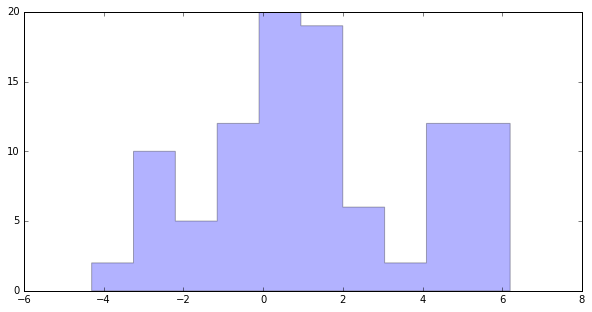

In [18]:
npr.seed(1)
n = 100
data = [-2+npr.randn() for _ in range(n//4)] + [1+npr.randn() for _ in range(n//2)] + [5
                                    +npr.randn() for _ in range(n//4)]
print(n==len(data))
plt.hist(data, histtype="stepfilled", alpha=.3)
plt.show()

Now let's run our naive Gibbs sampler.

In [19]:
alpha = 1.
sigma = 3.
tic = time.time()
gibbs = NaiveGibbsDPM(alpha,sigma,data)
numSteps = 100
for t in range(numSteps):
    if np.mod(t, numSteps/10)==0:
        print(100*t/numSteps, "%")
    gibbs.step()
print("Time elapsed:", (time.time()-tic)/60, "min")

0.0 %
10.0 %
20.0 %
30.0 %
40.0 %
50.0 %
60.0 %
70.0 %
80.0 %
90.0 %
Time elapsed: 214.97853260040284 min


In [20]:
# optional: save results
jobId = "n="+str(n)+"_alpha="+str(alpha)+"sigma="+str(sigma)
with open("gibbs_"+jobId+".pkl", 'wb') as f:
    pkl.dump(gibbs.mus, f)

In [308]:
# optional: load results
jobId = "n="+str(n)+"_alpha="+str(alpha)+"sigma="+str(sigma)
with open("gibbs_"+jobId+".pkl", 'rb') as f:
    mus = pkl.load(f) # careful, later cells work on gibbs.mus

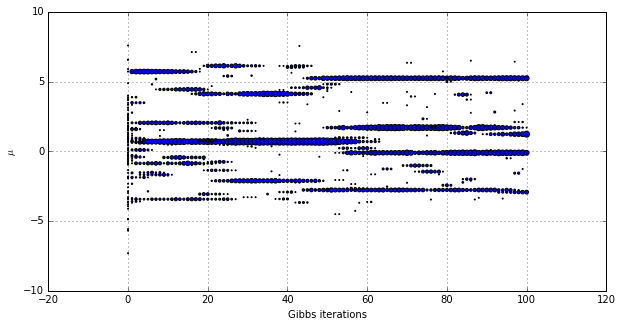

In [21]:
# Let us visualize the samples
for i in range(len(gibbs.mus)):
    u, w = np.unique(gibbs.mus[i], return_counts=1)
    plt.scatter([i]*len(u),u,marker='o',s=1.0*w)
plt.xlabel("Gibbs iterations")
plt.ylabel("$\mu$")
plt.grid(True)
plt.show()

What can you detect here? How would you suggest improving the sampler?

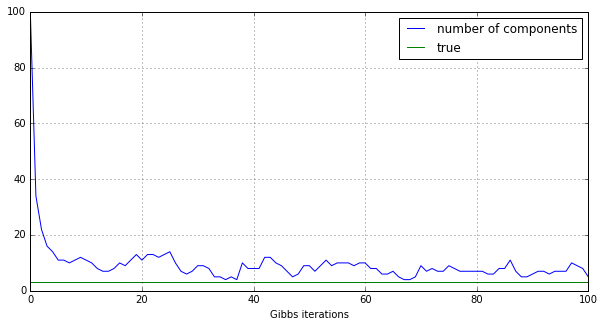

In [22]:
# Let us check the cardinality of each mu
cards = []
for i in range(len(gibbs.mus)):
    u = np.unique(gibbs.mus[i])
    cards.append(len(u))
plt.plot(cards, label="number of components")
plt.plot([0,numSteps], [3, 3], label="true")
plt.grid(True)
plt.xlabel("Gibbs iterations")
plt.legend()
plt.show()

Exercise: 
* Should we be worried that the actual value used in the simulation (3 components) is never visited? 
* What happens if you change $\alpha$?

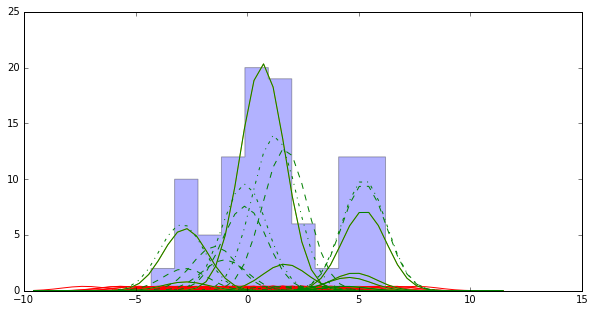

In [23]:
# First plot the data
plt.hist(data, alpha=.3, histtype='stepfilled')
m = np.min(data)
M = np.max(data)
delta = M-m
xPlot = np.linspace(m-.5*delta,M+.5*delta)

# Now plot a few samples
colors = ['red', 'orange', 'green', 'green', 'green']
styles = ['-', '-', '-', '--', '-.']
numIters = len(gibbs.mus)
iters = [0,50,numIters//2,3*numIters//4,-1] # We will plot the mu's for these three iterations
for i in range(len(iters)):
    iter = iters[i]
    color = colors[i]
    style = styles[i]
    u, w = np.unique(gibbs.mus[iter], return_counts=1)
    for i in range(len(u)):
        plt.plot(xPlot, w[i]*gibbs.lhd(xPlot,u[i]),color=color,linestyle=style)
plt.show()

Exercise: How would you use this posterior sample to cluster the observations?

This sample has cardinality 9
{0: 1, 1: 2, 2: 0, 3: 4, 4: 5, 5: 3, 6: 7, 7: 8, 8: 6}


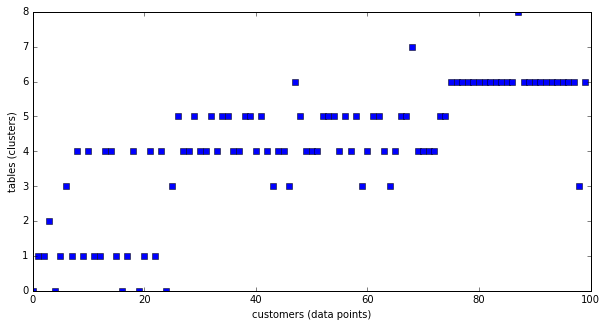

In [26]:
# Now we investigate the growth of the number of tables with arriving customers
mu = gibbs.mus[-3]
u, v, w = np.unique(mu, return_inverse=1, return_counts=1)
print("This sample has cardinality", len(u))
tableNumbers = []
tables = []

# we first label tables as they first appear
for i in range(gibbs.n):
    if not v[i] in tableNumbers:
        tableNumbers.append(v[i])

tableDict = dict(zip(tableNumbers,range(gibbs.n)))
print(tableDict)

# now we can plot the tables chosen by arriving customers
for i in range(gibbs.n):
    plt.plot(i,tableDict[v[i]],'s', color='b')
plt.xlabel("customers (data points)")
plt.ylabel("tables (clusters)")
plt.show()

What curve would you fit to #tables vs #customers? Why?

## McEachern's sampler
Exercise: implement McEachern's sampler as seen in class

## Variational approaches


Exercise: 
* implement a variational approach to inference for DP mixtures. 
* You can also check out the variational approaches proposed by toolboxes like [bnpy](https://github.com/bnpy/bnpy). 
* If you feel datasciency, check out general purpose probabilistic programming languages like [Edward](http://edwardlib.org/), they also provide tools for DP mixtures.